In [1]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import os
import sqlite3


# Checking logic of fucntions

In [2]:

def fetch_last_6_month_data(ticker="NVDA"):
    """"
    Fetch the last 6 month data for a stock from Yahoo Finance"""
    end_date = datetime.now().date()
    start_date = end_date - timedelta(days=180)
    df = yf.download(ticker, start=start_date, end=end_date)
    return df

In [3]:

def save_data_to_db(df, db_path="database/nvda_stock.db", table_name="nvidia_prices"):

    """"
    Store the fetched data in a SQLite database
    If the table does not exist, it will be created"""

    conn = sqlite3.connect(db_path)

    # Flatten MultiIndex columns

    df = df.copy()

    df.columns = [col[0] if col[0] != '' else col[1] for col in df.columns]

    df.reset_index(inplace=True)
    
    df["Date"] = df["Date"].dt.strftime('%Y-%m-%d')



    #create table if not exists
    df.to_sql(table_name, conn, if_exists="replace", index=False)



    # remove any existing data
    conn.execute(f"""
        DELETE FROM {table_name}
        WHERE rowid NOT IN (
            SELECT MIN(rowid)
            FROM {table_name}
            GROUP BY Date
        );
    """)
    conn.commit()

    conn.close()

    print(f"Data saved to {table_name} table")


In [4]:
from datetime import datetime, timedelta

df = fetch_last_6_month_data()

df.head()


[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,,
2024-06-21,126.550453,126.570000,130.630005,124.300003,127.120003,655484700
2024-06-24,118.091759,118.110001,124.459999,118.040001,123.239998,476060900
2024-06-25,126.070518,126.089996,126.500000,119.320000,121.199997,425787500
2024-06-26,126.380486,126.400002,128.119995,122.599998,126.129997,362975900
2024-06-27,123.970848,123.989998,126.410004,122.919998,124.099998,252571700


# data preprocessing


In [5]:
df.sort_values(by="Date", ascending=True, inplace=True)
df.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,,
2024-06-21,126.550453,126.570000,130.630005,124.300003,127.120003,655484700
2024-06-24,118.091759,118.110001,124.459999,118.040001,123.239998,476060900
2024-06-25,126.070518,126.089996,126.500000,119.320000,121.199997,425787500
2024-06-26,126.380486,126.400002,128.119995,122.599998,126.129997,362975900
2024-06-27,123.970848,123.989998,126.410004,122.919998,124.099998,252571700


<Axes: title={'center': 'NVDA Stock Price'}, xlabel='Date', ylabel='Price (USD)'>

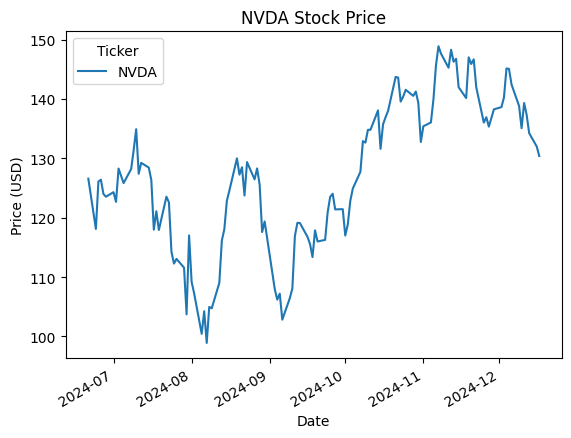

In [6]:
df["Close"].plot(title="NVDA Stock Price", ylabel="Price (USD)", xlabel="Date")


In [7]:
df2 = df.copy()
df2["Change(%)"] = df2["Close"].pct_change() 
df2.dropna(inplace=True)

df2 = df2[["Close", "Change(%)"]]
df2.head()

Price,Close,Change(%)
Ticker,NVDA,
Date,,
2024-06-24,118.110001,-0.066840
2024-06-25,126.089996,0.067564
2024-06-26,126.400002,0.002459
2024-06-27,123.989998,-0.019066
2024-06-28,123.540001,-0.003629


# Loading model

In [8]:
import mlflow
import mlflow.keras

model_path = "/home/abdullah/ai_workspace/project/Stock_prediction_project/shared_model/nvda_stock_model"
model = mlflow.keras.load_model(model_path)

model.summary()


2024-12-18 11:34:40.093914: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734521680.105459   16400 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734521680.108744   16400 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-18 11:34:40.122147: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1734521681.252491   16400 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 30, 50)         │        10,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 30, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 157,607 (615.66 KB)

 Trainable params: 52,535 (205.21 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 105,072 (410.44 KB)

# Testing if main script works

In [9]:
from data_preprocessing import DataPreprocessor
from model_finetuning import ModelFinetuner
from fetch_data import DataFetcher

db_path = "/home/abdullah/ai_workspace/project/Stock_prediction_project/finetuning_service/app/utils/database/nvda_stock.db"
scaled_db_path = "/home/abdullah/ai_workspace/project/Stock_prediction_project/finetuning_service/app/utils/database/nvda_stock_scaled.db"
model_path = "/home/abdullah/ai_workspace/project/Stock_prediction_project/shared_model/nvda_stock_model"
scaler_path = "/home/abdullah/ai_workspace/project/Stock_prediction_project/finetuning_service/app/utils/scaler.pkl"
fine_tuned_model_path = "/home/abdullah/ai_workspace/project/Stock_prediction_project/shared_model/fine_tuned_model"

# Instantiate each class
fetcher = DataFetcher(db_path=db_path)
preprocessor = DataPreprocessor(raw_db_path=db_path, scaled_db_path=scaled_db_path, scaler_path=scaler_path)
finetuner = ModelFinetuner(scaled_db_path=scaled_db_path,model_path=model_path, fine_tuned_model_path=fine_tuned_model_path)

# Run fetch step
fetcher.run()
# Run preprocessing step
preprocessor.run()
# Run finetuning step
finetuner.run()

print("All steps (fetch, preprocess, finetune) completed.")

[*********************100%***********************]  1 of 1 completed

Data saved to nvidia_prices in /home/abdullah/ai_workspace/project/Stock_prediction_project/finetuning_service/app/utils/database/nvda_stock.db
Data fetching complete.
Scaled data stored in /home/abdullah/ai_workspace/project/Stock_prediction_project/finetuning_service/app/utils/database/nvda_stock_scaled.db, table: scaled_nvidia_prices
Scaler saved to: /home/abdullah/ai_workspace/project/Stock_prediction_project/finetuning_service/app/utils/scaler.pkl
Data preprocessing complete.
X shape: (85, 30, 2), y shape: (85, 10)
X_train data shape: (76, 30, 2), y_train data shape: (76, 10)
Epoch 1/10


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 216ms/step - loss: 0.1141 - mae: 0.2604 - val_loss: 0.0261 - val_mae: 0.1383
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0917 - mae: 0.2309 - val_loss: 0.0101 - val_mae: 0.0792
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.1294 - mae: 0.2747 - val_loss: 0.0101 - val_mae: 0.0765
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0777 - mae: 0.2162 - val_loss: 0.0095 - val_mae: 0.0733
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0778 - mae: 0.2152 - val_loss: 0.0097 - val_mae: 0.0773
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0869 - mae: 0.2261 - val_loss: 0.0133 - val_mae: 0.0931
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0777 - mae: 0.2196 - val_loss: 0.0097 - val_mae: 0.0790


2024/12/18 11:34:46 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Model fine-tuning completed and updated model saved at /home/abdullah/ai_workspace/project/Stock_prediction_project/shared_model/fine_tuned_model.
All steps (fetch, preprocess, finetune) completed.


In [10]:
import sqlite3

conn = sqlite3.connect(db_path)

tables = conn.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
print(f"Tables: {tables}")

df_check = pd.read_sql_query("SELECT * FROM nvidia_prices LIMIT 5", conn)
print(f"Columns in nvidia_prices table: {df_check.columns}")
print(df_check.head())

conn.close()

Tables: [('nvidia_prices',)]
Columns in nvidia_prices table: Index(['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')
         Date   Adj Close       Close        High         Low        Open  \
0  2024-06-21  126.550453  126.570000  130.630005  124.300003  127.120003   
1  2024-06-24  118.091759  118.110001  124.459999  118.040001  123.239998   
2  2024-06-25  126.070518  126.089996  126.500000  119.320000  121.199997   
3  2024-06-26  126.380486  126.400002  128.119995  122.599998  126.129997   
4  2024-06-27  123.970848  123.989998  126.410004  122.919998  124.099998   

      Volume  
0  655484700  
1  476060900  
2  425787500  
3  362975900  
4  252571700  


In [11]:

import pytest
from fetch_data import DataFetcher

@pytest.mark.integration
def test_yahoo_api_fetch():
    # Initialize DataFetcher with default ticker (NVDA)
    fetcher = DataFetcher(ticker="NVDA")

    # Run fetch_data method
    df = fetcher.fetch_data()

    # Check if DataFrame is not empty
    assert not df.empty, "Fetched data should not be empty."

    # Check if 'Close' column is present
    assert 'Close' in df.columns, "DataFrame should contain 'Close' column."

    # Check a few basic conditions, like the shape of the DataFrame
    # ensuring at least some rows and columns
    assert df.shape[0] > 0, "DataFrame should have at least one row."
    assert df.shape[1] >= 2, "DataFrame should have at least 5 columns (Open, High, Low, Close, Volume)."

    print("Test passed: Yahoo Finance API fetch is working as expected.")

test_yahoo_api_fetch()


[*********************100%***********************]  1 of 1 completed

Test passed: Yahoo Finance API fetch is working as expected.
